In [1]:
from skimage import color, io, measure, util, data, morphology
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, matrix_transform, SimilarityTransform, EuclideanTransform, warp, swirl
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.decomposition import PCA
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, label2rgb
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v, prewitt, median
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening, square
from skimage.segmentation import clear_border
from scipy.stats import norm
from scipy.spatial import distance
import scipy.io as sio
import glob
import os
import SimpleITK as sitk
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler

1

In [8]:
matrix = np.matrix([[177,195,181,30,192],
                    [81,203,192,127,65],
                    [242,48,70,245,129],
                    [9,125,173,87,178],
                    [112,114,167,149,227]])

import numpy as np

def find_optimal_path(matrix):
    num_rows, num_cols = matrix.shape
    # Create a cost matrix initialized with infinity
    cost = np.full((num_rows, num_cols), float('inf'))
    # Initialize the first row of the cost matrix
    cost[0, :] = matrix[0, :]

    # Populate the cost matrix
    for i in range(1, num_rows):
        for j in range(num_cols):
            # Cost to reach the current cell from directly above
            min_cost = cost[i-1, j]
            # Cost to reach the current cell from above-left
            if j > 0:
                min_cost = min(min_cost, cost[i-1, j-1])
            # Cost to reach the current cell from above-right
            if j < num_cols - 1:
                min_cost = min(min_cost, cost[i-1, j+1])
            # Update the cost matrix with the minimum cost found
            cost[i, j] = matrix[i, j] + min_cost

    # Backtrack to find the path
    path = []
    min_cost_index = np.argmin(cost[-1, :])
    for i in range(num_rows - 1, -1, -1):
        path.append((i + 1, min_cost_index + 1))  # Convert to 1-based coordinates
        if i > 0:
            # Check neighbors to find the previous cell
            prev_index = min_cost_index
            min_cost = cost[i-1, prev_index]
            if min_cost_index > 0 and cost[i-1, min_cost_index-1] < min_cost:
                min_cost = cost[i-1, min_cost_index-1]
                prev_index = min_cost_index - 1
            if min_cost_index < num_cols - 1 and cost[i-1, min_cost_index+1] < min_cost:
                prev_index = min_cost_index + 1
            min_cost_index = prev_index

    path.reverse()  # Reverse to start from the top of the matrix
    return path

# Matrix definitio

# Calculate the optimal path
optimal_path = find_optimal_path(matrix)
optimal_path

optimal_path_indices = [(0, 3), (1, 2), (2, 1), (3, 0), (4, 0)]
path_values = [matrix[i, j] for i, j in optimal_path_indices]
print(path_values)
# Calculate the median value of the values on the optimal path
median_value = np.median(path_values)
median_value


[30, 192, 48, 9, 112]


48.0

2

In [9]:
import numpy as np

# Given matrix
matrix = np.array([
    [177, 195, 181, 30, 192],
    [81, 203, 192, 127, 65],
    [242, 48, 70, 245, 129],
    [9, 125, 173, 87, 178],
    [112, 114, 167, 149, 227]
])

# Initialize the accumulator matrix with the same size as the original matrix
accumulator = np.zeros_like(matrix)

# Set the first row of the accumulator to be equal to the first row of the matrix
accumulator[0, :] = matrix[0, :]

# Fill the accumulator matrix
for i in range(1, matrix.shape[0]):
    for j in range(matrix.shape[1]):
        # Handle the border cases
        if j == 0:
            accumulator[i, j] = matrix[i, j] + min(accumulator[i-1, j], accumulator[i-1, j+1])
        elif j == matrix.shape[1] - 1:
            accumulator[i, j] = matrix[i, j] + min(accumulator[i-1, j-1], accumulator[i-1, j])
        else:
            accumulator[i, j] = matrix[i, j] + min(accumulator[i-1, j-1], accumulator[i-1, j], accumulator[i-1, j+1])

# Find the path by backtracking from the bottom row
path_indices = []
current_col = np.argmin(accumulator[-1])
path_indices.append((matrix.shape[0] - 1, current_col))

for i in range(matrix.shape[0] - 1, 0, -1):
    current_row = i
    if current_col == 0:
        next_col = np.argmin(accumulator[current_row-1, current_col:current_col+2]) + current_col
    elif current_col == matrix.shape[1] - 1:
        next_col = np.argmin(accumulator[current_row-1, current_col-1:current_col+1]) + current_col - 1
    else:
        next_col = np.argmin(accumulator[current_row-1, current_col-1:current_col+2]) + current_col - 1

    path_indices.append((current_row - 1, next_col))
    current_col = next_col

# Extract the values from the accumulator along the path
path_values = [accumulator[row, col] for row, col in path_indices]

# Calculate the median of the path values
median_path_value = np.median(path_values)
median_path_value, path_values


(270.0, [391, 279, 270, 222, 30])

3

In [10]:

# Load DICOM file
dicom_path = 'Aorta/1-442.dcm'
ds = dicom.dcmread(dicom_path)

# Load the mask image
mask_path = 'Aorta/AortaROI.png'
mask = io.imread(mask_path)

# Convert mask to boolean
mask_bool = mask > 0  # Assuming the mask image is already binary

# Apply the mask to the DICOM image
aorta_pixels = ds.pixel_array[mask_bool]

# Calculate average and standard deviation of the grey values
average_grey_value = np.mean(aorta_pixels)
standard_deviation_grey_value = np.std(aorta_pixels)

print("Average grey-value of the blood in the aorta:", average_grey_value)
print("Standard deviation of grey-values of the blood in the aorta:", standard_deviation_grey_value)

Average grey-value of the blood in the aorta: 206.99287410926365
Standard deviation of grey-values of the blood in the aorta: 12.658963440876713


4

In [7]:
matrix = np.array([[208, 208, 208, 202, 202, 202],
                   [231, 231, 231, 231, 193, 193],
                   [193, 193, 193, 167, 167, 167],
                   [167, 36, 36, 36, 36, 36],
                   [36, 40, 40, 217, 217, 217],
                   [25, 25, 25, 25, 25, 25]])

# Apply threshold of 230
threshold = 230
binary_image = (matrix > threshold).astype(int)

# Display the binary image
print("Binary Image:")
print(binary_image)

# Chain Code Implementation (simplified and needs a starting point and specific direction handling)
def get_chain_code(binary_img):
    # Typically we would find the starting point by traversing the image,
    # and we would need the specific boundary following logic.
    # This is a placeholder for illustrative purposes.
    pass

# Run-Length Encoding
def run_length_encoding(binary_img):
    encoded = []
    for i, row in enumerate(binary_img):
        start = None
        for j, value in enumerate(row):
            if value == 1 and start is None:
                start = j
            elif value == 0 and start is not None:
                encoded.append(f"[{i}; ({start}, {j})]")
                start = None
        if start is not None:
            encoded.append(f"[{i}; ({start}, {len(row)})]")
    return encoded

# Perform run-length encoding
rle = run_length_encoding(binary_image)
print("Run-Length Encoded Output:")
print(rle)

Binary Image:
[[0 0 0 0 0 0]
 [1 1 1 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
Run-Length Encoded Output:
['[1; (0, 4)]']


5

Number of BLOBs: 2
Areas of remaining BLOBs: [8158.0, 1047.0]


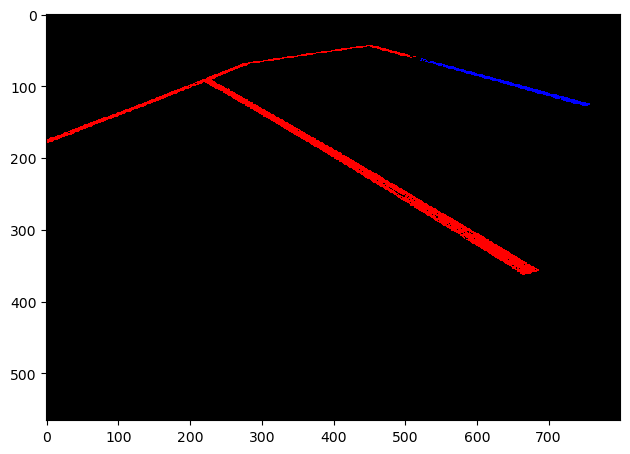

In [8]:


image_path = 'CarData/road.png'
image = io.imread(image_path)

# Convert to HSV and select the V channel
hsv_image = color.rgb2hsv(image)
v_channel = hsv_image[:, :, 2]

# Threshold the V channel
binary_image = v_channel > 0.9

# Label the image
labeled_image = measure.label(binary_image, connectivity=2)

# Measure properties of each BLOB
regions = measure.regionprops(labeled_image)

# Filter BLOBs based on their area
areas = [region.area for region in regions]
sorted_areas = sorted(areas, reverse=True)

# Assuming we need to keep only two largest BLOBs
if len(sorted_areas) > 2:
    min_area = sorted_areas[1]  # The second largest area

# Now, filter out BLOBs smaller than the determined minimum area
filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_area)

# Recompute BLOBs and areas to validate
final_labels = measure.label(filtered_image, connectivity=2)
final_regions = measure.regionprops(final_labels)
final_areas = [region.area for region in final_regions]

# Display the number of remaining BLOBs and their areas
print(f'Number of BLOBs: {len(final_areas)}')
print(f'Areas of remaining BLOBs: {final_areas}')

# Visualize the final image
io.imshow(color.label2rgb(final_labels, bg_label=0))
io.show()

6

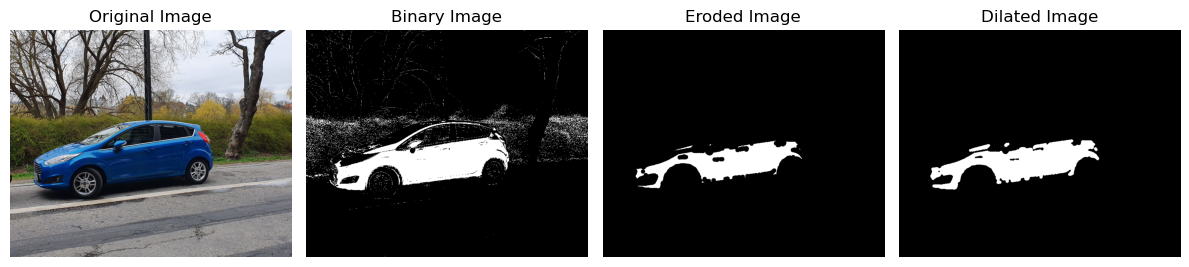

Number of foreground pixels: 31365


In [10]:
image_path = 'CarData/car.png'

image = io.imread(image_path)

# Convert to HSV color space
hsv_image = color.rgb2hsv(image)

# Extract the S component
s_channel = hsv_image[:, :, 1]

# Create a binary image by thresholding the S component
binary_image = s_channel > 0.7

# Perform morphological erosion
selem = disk(6)
eroded_image = erosion(binary_image, selem)

# Perform morphological dilation
selem = disk(4)
dilated_image = dilation(eroded_image, selem)

# Display the results
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
ax = axes.ravel()

ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(binary_image, cmap='gray')
ax[1].set_title("Binary Image")
ax[1].axis('off')

ax[2].imshow(eroded_image, cmap='gray')
ax[2].set_title("Eroded Image")
ax[2].axis('off')

ax[3].imshow(dilated_image, cmap='gray')
ax[3].set_title("Dilated Image")
ax[3].axis('off')

plt.tight_layout()
plt.show()

foreground_pixels = np.sum(dilated_image)

print("Number of foreground pixels:", foreground_pixels)

7

In [22]:
image_files = [f'ImagePCA/spoon{i}.png' for i in range(1, 7)]
images = [io.imread(img_file) for img_file in image_files]
# Convert to grayscale if they are not already
# Convert to grayscale if they are not already
gray_images = [rgb2gray(img) if img.ndim > 2 else img for img in images]

# Convert all images to float type for averaging
gray_images = [img_as_float(img) for img in gray_images]

# Calculate the average image
average_image = np.mean(gray_images, axis=0)

# Convert the average image back to original pixel values
average_image_uint8 = img_as_ubyte(average_image)

# Access the pixel value at (row=500, column=100) in 1-based index
pixel_value = average_image_uint8[499, 99]  # Convert to 0-based index by subtracting 1

print("The pixel value at (row=500, column=100) in the average image is:", pixel_value)

The pixel value at (row=500, column=100) in the average image is: 190


8

In [31]:
def sortem(V, D):
    # D is expected to be a 1D array of eigenvalues
    # V is the matrix of eigenvectors
    sorted_indices = np.argsort(D)[::-1]  # Sort indices of eigenvalues in descending order
    NV = V[:, sorted_indices]  # Reorder eigenvectors according to sorted indices
    ND = D[sorted_indices]  # Sorted eigenvalues
    return NV, ND

def pc_evectors(A, numvecs):
    nexamp = A.shape[1]
    Psi = np.mean(A, axis=1, keepdims=True)
    A_centered = A - Psi
    L = A_centered.T @ A_centered  # Covariance-like matrix
    eigenvalues, eigenvectors = np.linalg.eigh(L)  # Using eigh which is more stable for symmetric matrices
    eigenvectors, eigenvalues = sortem(eigenvectors, eigenvalues)
    eigenvectors = A_centered @ eigenvectors
    eigenvalues /= (nexamp - 1)  # Adjust eigenvalues
    
    for i in range(eigenvectors.shape[1]):
        eigenvectors[:, i] /= np.linalg.norm(eigenvectors[:, i])  # Normalize vectors
        if eigenvalues[i] < 1e-5:  # Thresholding small eigenvalues
            eigenvalues[i] = 0
            eigenvectors[:, i] = np.zeros(eigenvectors.shape[0])

    return eigenvectors[:, :numvecs], eigenvalues[:numvecs]

# Load and preprocess images
# A is the matrix where each column is a flattened binary image
image_names = ['spoon1.png', 'spoon2.png', 'spoon3.png', 'spoon4.png', 'spoon5.png', 'spoon6.png']
folder_path = 'ImagePCA/'
image_vectors = []

for name in image_names:
    # Load the image
    img_path = folder_path + name
    img = io.imread(img_path)

    # Check if the image has three dimensions (color image)
    if img.ndim == 3 and img.shape[2] == 3:
        # Convert color image to grayscale
        gray_img = color.rgb2gray(img)
    else:
        # Assume the image is already grayscale
        gray_img = img

    # Normalize the grayscale image to float [0, 1]
    gray_img = img_as_float(gray_img)
    
    # Apply threshold to create binary image
    binary_img = np.where(gray_img > 0.392, 1, 0)  # 100/255 approx 0.392

    # Flatten the binary image to a vector
    img_vector = binary_img.flatten()
    
    # Append the vector to the list
    image_vectors.append(img_vector)

# Stack vectors as columns in a matrix A
A = np.column_stack(image_vectors)

# Now A is ready to use for PCA
print("Data matrix A is prepared with shape:", A.shape)

# Assuming you have loaded and preprocessed your images into the matrix A
num_components = 6
Vectors, Values = pc_evectors(A, num_components)

# Calculate the percentage of total variation that the first principal component explains
total_variance = np.sum(Values)
first_component_variance = Values[0]
percentage_explained = (first_component_variance / total_variance) * 100

print(f"Percentage of total variation explained by the first principal component: {percentage_explained:.2f}%")


# Here you would proceed with PCA as described earlier

Data matrix A is prepared with shape: (110000, 6)
Percentage of total variation explained by the first principal component: 43.96%


9

In [41]:
image_files = [f'ImagePCA/spoon{i}.png' for i in range(1, 7)]
images = [(io.imread(file)).flatten() for file in image_files]

# Create a matrix where each row is an image
X = np.array(images)

# Normalize the data by subtracting the mean image
mean_image = np.mean(X, axis=0)
X_centered = X - mean_image

# Compute PCA
pca = PCA()
X_pca = pca.fit_transform(X_centered)

# Determine the number of components to retain at least 65% of the total variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(cumulative_variance >= 0.65)[0][0] + 1

# Project the first image (spoon1.png) into the PCA space
X_projected = np.dot(X_centered, pca.components_[:n_components].T)

# Print the coordinates of the first image in the PCA space
print("Coordinates of spoon1.png in the PCA space:", X_projected[0])

Coordinates of spoon1.png in the PCA space: [8592.73985484 7148.91164974]


In [42]:
angle_degrees = 20
angle_radians = np.deg2rad(angle_degrees)

# Rotation matrix
rotation_matrix = np.array([
    [np.cos(angle_radians), -np.sin(angle_radians)],
    [np.sin(angle_radians), np.cos(angle_radians)]
])

# Scaling matrix
scaling_factor = 2
scaling_matrix = np.array([
    [scaling_factor, 0],
    [0, scaling_factor]
])

# Translation vector
translation_vector = np.array([3.1, -3.3])

# Initial point
point = np.array([10, 10])

# Apply rotation
rotated_point = np.dot(rotation_matrix, point)

# Apply scaling
scaled_point = np.dot(scaling_matrix, rotated_point)

# Apply translation
transformed_point = scaled_point + translation_vector

# Output the final transformed point
print("Transformed Point:", transformed_point)

Transformed Point: [15.05344955 22.33425528]


10

In [44]:
points = np.array([(1,13), (2,9), (4,4), (5,2), (5,5), (5,12), (7,7), (10,4), (12,9), (13,9)])
thetas = [0, 0, -45, 90, 45]  # degrees
rhos = [10.0, 5.0, -4.9, 9.0, 9.9]  # corresponding rhos

theta_radians = np.deg2rad(thetas)

# Check each point against each (rho, theta)
for i, (rho, theta) in enumerate(zip(rhos, theta_radians)):
    computed_rhos = points[:, 0] * np.cos(theta) + points[:, 1] * np.sin(theta)
    # Find points where computed rho is close to the given rho
    close_points = np.isclose(computed_rhos, rho, atol=0.1)
    print(f"Line {i + 1} (rho={rhos[i]}, theta={thetas[i]} degrees) fits {np.sum(close_points)} points.")
    if np.sum(close_points) >= 2:  # At least two points are close
        print(f"Line {i + 1} (rho={rhos[i]}, theta={thetas[i]} degrees) fits {np.sum(close_points)} points.")

Line 1 (rho=10.0, theta=0 degrees) fits 1 points.
Line 2 (rho=5.0, theta=0 degrees) fits 3 points.
Line 2 (rho=5.0, theta=0 degrees) fits 3 points.
Line 3 (rho=-4.9, theta=-45 degrees) fits 2 points.
Line 3 (rho=-4.9, theta=-45 degrees) fits 2 points.
Line 4 (rho=9.0, theta=90 degrees) fits 3 points.
Line 4 (rho=9.0, theta=90 degrees) fits 3 points.
Line 5 (rho=9.9, theta=45 degrees) fits 3 points.
Line 5 (rho=9.9, theta=45 degrees) fits 3 points.


12

In [3]:
# Data for passive and erupting volcanoes
X = np.array([
    [1.2, 1.1], [2.9, 0.4], [1.7, -2.7], [1.8, -0.3], [3.2, 1.3], [3.1, -0.9],  # Passive volcanoes
    [0.5, 1.7], [1.4, -2.1], [2.7, -0.8], [2.0, 0.5]                            # Erupting volcanoes
])

# Labels for passive (class 1) and erupting (class 2)
y = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])  # 0 for passive, 1 for erupting

# Function to perform LDA
def LDA(X, y):
    n, m = X.shape
    class_label = np.unique(y)
    k = len(class_label)
    
    n_group = np.zeros((k, 1))
    group_mean = np.zeros((k, m))
    pooled_cov = np.zeros((m, m))
    W = np.zeros((k, m + 1))
    
    for i in range(k):
        group = y == class_label[i]
        n_group[i] = np.sum(group)
        group_mean[i, :] = np.mean(X[group, :], axis=0)
        pooled_cov += ((n_group[i] - 1) / (n - k)) * np.cov(X[group, :], rowvar=False)
    
    prior_prob = n_group / n
    
    for i in range(k):
        temp = group_mean[i, :][np.newaxis] @ np.linalg.inv(pooled_cov)
        W[i, 0] = -0.5 * temp @ group_mean[i, :].T + np.log(prior_prob[i])
        W[i, 1:] = temp
    
    return W

# Train the LDA model
W = LDA(X, y)

# Display the learned weights
print("Learned weight matrix W (including bias term as the first column):")
print(W)

# Compute discriminant scores for each class
def compute_scores(X, W):
    scores = np.dot(X, W[:, 1:].T) + W[:, 0]  # W[:, 1:] are the weights, W[:, 0] is the bias
    return scores

# Compute class probabilities using softmax
def softmax(scores):
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Using the trained model to compute the discriminant scores
scores = compute_scores(X, W)
probabilities = softmax(scores)

# Print the probabilities for each sample
print("Probabilities of each sample belonging to each class:")
print(probabilities)

# Find misclassified samples
predicted_classes = np.argmax(probabilities, axis=1)
misclassified_indices = np.where((predicted_classes != y) & (y == 1))[0]  # Class 2 is erupting volcanoes

print("Indices of misclassified erupting volcanoes:", misclassified_indices)
print("Probabilities of these misclassified erupting volcanoes:")
print(probabilities[misclassified_indices])

# Extract and display only the probabilities for the erupting class
erupting_probabilities = probabilities[misclassified_indices, 1]
print("Probabilities of misclassified erupting volcanoes belonging to erupting class:")
print(erupting_probabilities)

Learned weight matrix W (including bias term as the first column):
[[-3.9553119   2.97777621  0.05204909]
 [-2.66235025  2.11838433  0.01837208]]
Probabilities of each sample belonging to each class:
[[0.44407333 0.55592667]
 [0.77078439 0.22921561]
 [0.51925962 0.48074038]
 [0.56065989 0.43934011]
 [0.81770456 0.18229544]
 [0.79262868 0.20737132]
 [0.30874037 0.69125963]
 [0.45995229 0.54004771]
 [0.73114799 0.26885201]
 [0.60889282 0.39110718]]
Indices of misclassified erupting volcanoes: [8 9]
Probabilities of these misclassified erupting volcanoes:
[[0.73114799 0.26885201]
 [0.60889282 0.39110718]]
Probabilities of misclassified erupting volcanoes belonging to erupting class:
[0.26885201 0.39110718]


14

In [8]:
# Load the data
soccer_data = np.loadtxt("PCAData/soccer_data.txt", comments="%")
# Initialize PCA
pca = PCA(n_components=6)

# Fit the PCA model to the data
pca.fit(soccer_data)

# Transform the data into PCA space
transformed_data = pca.transform(soccer_data)

# Compute the maximum absolute value of the projected data
max_absolute_value = np.max(np.abs(transformed_data))

print("The maximum value of absolute value of all the projected player values is:", max_absolute_value)

The maximum value of absolute value of all the projected player values is: 106.07883060049045


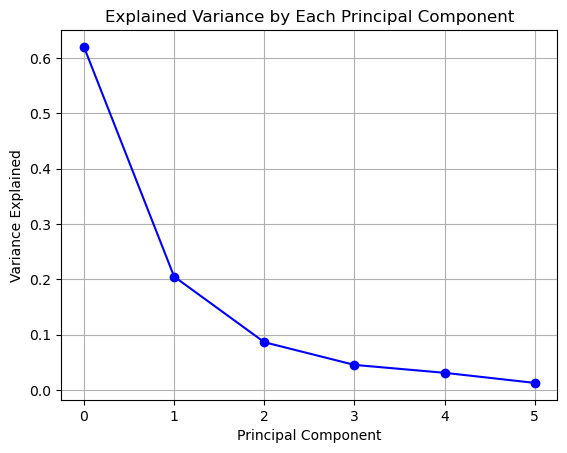

In [9]:
# Variance ratios (the amount of variance that each PC explains)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure()
plt.plot(explained_variance_ratio, marker='o', linestyle='-', color='b')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)


15

In [36]:
import scipy.io

img_fixed = io.imread('Landmarks/play1.png')
img_moving = io.imread('Landmarks/play5.png')
reference_image = io.imread('Landmarks/reference.png')

# Load landmark points
fixed_points = scipy.io.loadmat('Landmarks/playfixedPoints.mat')['fixedPoints']
moving_points = scipy.io.loadmat('Landmarks/playmovingPoints.mat')['movingPoints']

# Calculate the similarity transform
tform = SimilarityTransform()
tform.estimate(moving_points, fixed_points)  # Note: Parameters might be reversed depending on convention
# Apply the transform to the moving image with explicit output shape
warped_image = warp(img_moving, tform.inverse, output_shape=(reference_image.shape[0], reference_image.shape[1]))

print(warped_image.ndim)
if warped_image.ndim == 3:
    warped_image_gray = rgb2gray(warped_image)
else:
    warped_image_gray = warped_image
def dice_score(img, gt_bin):
    # Calculate the dice score
    dice_score = 1 - distance.dice(img.ravel(), gt_bin.ravel())
    return dice_score

# Create binary images
binary_transformed = (warped_image_gray < 180)  # Foreground pixels where pixel value < 180
# binary_reference = (reference_image > 0).astype(int)  # Assuming reference image is already binary

# Compute DICE score
dice_score = dice_score(binary_transformed, reference_image)
print(f"DICE score: {dice_score}")

3
DICE score: 0.7308756175033518


In [37]:
# Select the first landmarks from both fixed and moving
fixed_first = fixed_points[0]
moving_first = moving_points[0]

# Compute Euclidean distance
distance = np.linalg.norm(fixed_first - moving_first)
print(f"Euclidean distance between the first landmarks: {distance}")

Euclidean distance between the first landmarks: 165.7348824957671


16

In [39]:
# Define the means and standard deviations
mu_medium = 52
std_medium = 2
mu_high = 150
std_high = 30

# Define a range of pixel values to evaluate the probability density functions
pixel_values = np.linspace(0, 200, 1000)

# Calculate PDFs for both distributions
pdf_medium = norm.pdf(pixel_values, mu_medium, std_medium)
pdf_high = norm.pdf(pixel_values, mu_high, std_high)

# Find the intersection point
intersection = np.argwhere(np.diff(np.sign(pdf_medium - pdf_high))).flatten()

# The pixel value at the intersection
threshold_value = pixel_values[intersection]
print(f"The pixel value that separates medium from high quality grain is approximately: {threshold_value}")

The pixel value that separates medium from high quality grain is approximately: [43.44344344 59.45945946]


17

In [40]:
mean_bad = 25
mean_medium = 52

# Calculate the threshold as the midpoint between the two means
threshold_bad_medium = (mean_bad + mean_medium) / 2
print(f"The pixel value that separates bad from medium quality grain is: {threshold_bad_medium}")

The pixel value that separates bad from medium quality grain is: 38.5
